In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100

In [3]:
swap = swaption.set_index(['Expiry', 'Tenor'])

In [4]:
bps = np.array([0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))])

In [5]:
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [6]:
semi_annual_DF = pd.read_csv('discount_factor.csv', header = 0, index_col = 0).reset_index()

In [7]:
yearly_DF = pd.read_csv('yearly_DF.csv', header = 0, index_col = 0)

In [8]:
def Black76Call(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD_Put(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Put(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

In [9]:
def Black76(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if F <= K:
        black_price =  pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))
    else:
        black_price =  pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    return black_price


def DD(F, K, sigma, pvbp, beta, T):
    if F <= K:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    else:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Put(F_d, K_d, sigma_d, pvbp, T)
        
    return price

In [10]:
def volatility(F, K, pvbp, T, sigma, beta):
    
    #price = DD(F, K, sigma, pvbp, beta, T)
    
    if F <= K:
        price = DD_Call(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = DD_Put(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

In [11]:
def ddcalibration(x,  F, strikes, vols, pvbp,  T):
    err = 0.0
    sigma = vols[5]
    
    for i, vol in enumerate(vols):
        
        err += (vol - volatility( F, strikes[i], pvbp,  T, sigma, x))**2

    return err

## 1. Calibration the DD model

In [12]:
Expiry=['1Y','5Y','10Y']
Tenor=['1Y','2Y','3Y','5Y','10Y']

In [13]:
initialGuess = [0.3]

In [14]:
Cal_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
Cal_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [15]:
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        
        res = least_squares(lambda x: ddcalibration(x, fwd, strikes, 
                                                    market_vol, pvbp, T = ex_int), initialGuess,
                                                    bounds=([0,1]))
        
        Cal_Beta[te][ex]= res.x
        Cal_Sigma[te][ex]= market_vol[5]

In [16]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [17]:
Cal_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,5.801818e-08,3.133166e-13,1.087411e-12,1.475881e-10,0.000007
5Y,1.310269e-11,5.503210e-08,2.277114e-06,1.432631e-04,0.055462
10Y,1.396061e-07,7.489292e-06,8.155062e-05,1.387962e-06,0.001745


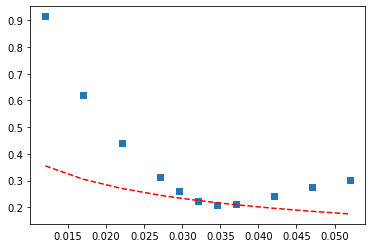

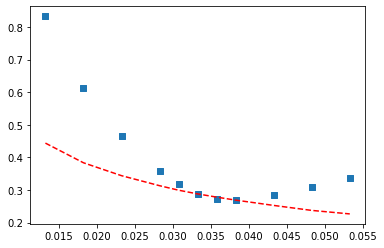

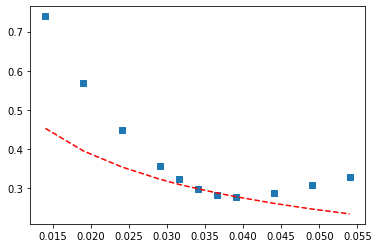

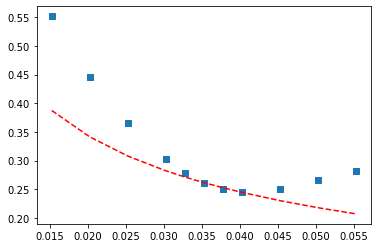

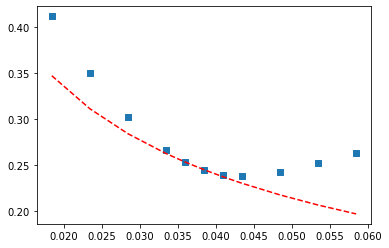

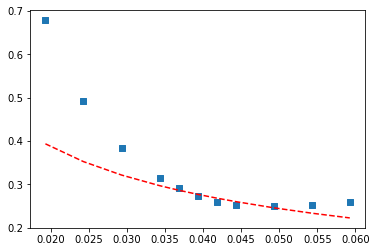

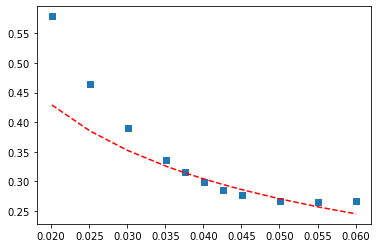

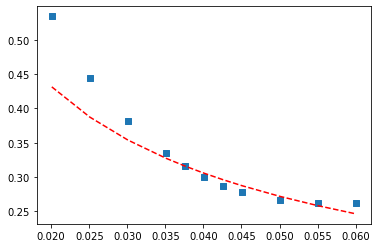

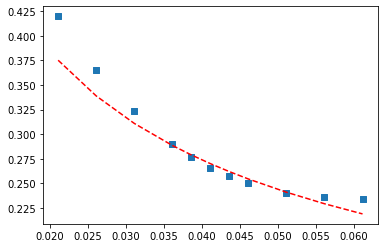

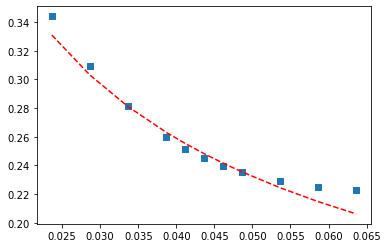

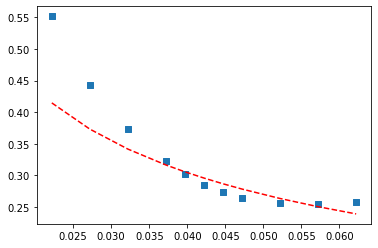

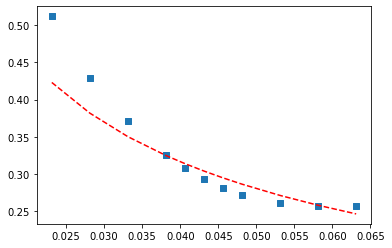

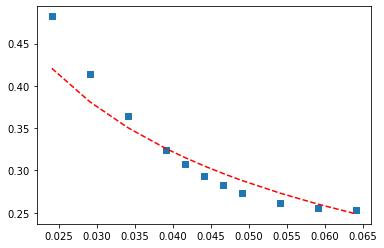

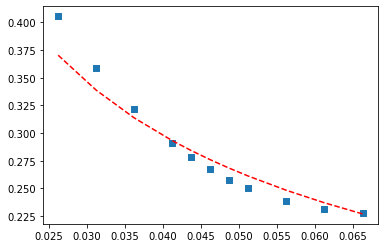

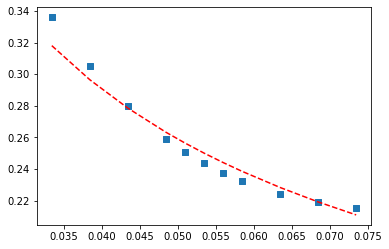

In [18]:
# plot the calibrated DD model with the market vols 
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        
        plt.figure()
        plt.scatter(strikes, market_vols,marker = 's')
        plt.plot(strikes, DD_vols, '--r')

## 2. SABR calibration

In [19]:
beta = 0.9

In [20]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

In [21]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [22]:
initialGuess_sabr=[0.1,-0.5,0.5]

In [23]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
    
        T=int(ex[:-1])
       
        res=least_squares(lambda x: sabrcalibration(x,
                                           strikes,
                                           market_vol,
                                           fwd,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [24]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139066,0.184649,0.196848,0.178052,0.171041
5Y,0.166534,0.199506,0.210347,0.191124,0.177190
10Y,0.177491,0.195212,0.207145,0.201713,0.180075


In [25]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633245,-0.525117,-0.482843,-0.414426,-0.264456
5Y,-0.585236,-0.546914,-0.549777,-0.511623,-0.438771
10Y,-0.545528,-0.544212,-0.550701,-0.562976,-0.506955


In [26]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049553,1.677404,1.438162,1.064877,0.778224
5Y,1.339731,1.061937,0.936723,0.671311,0.495728
10Y,1.006900,0.925232,0.869004,0.719768,0.579937


In [27]:
def sabrvol(F, K, pvbp, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76Call(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = Black76Put(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

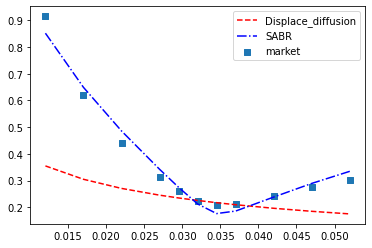

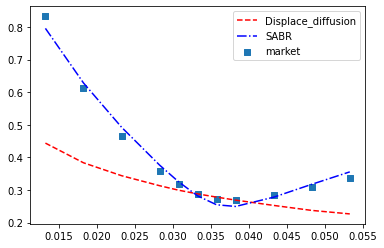

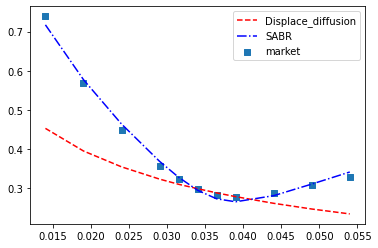

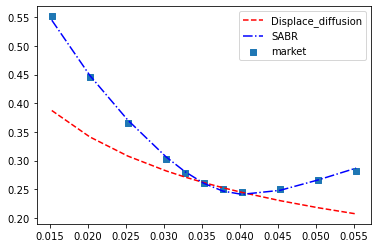

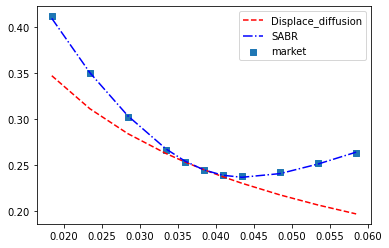

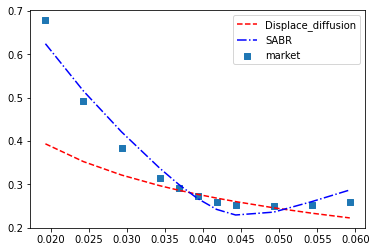

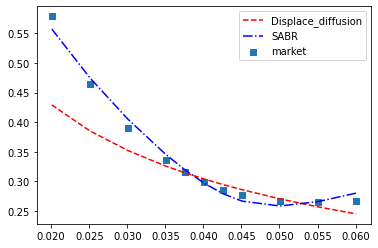

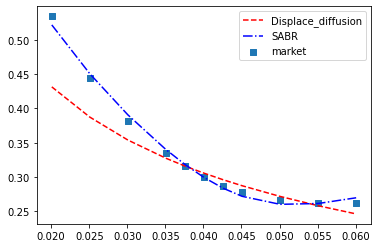

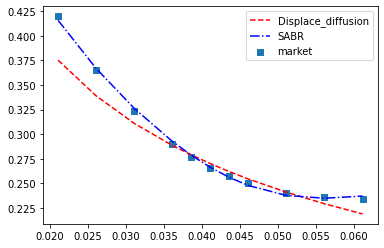

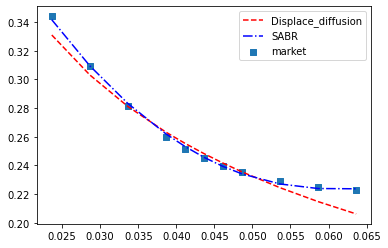

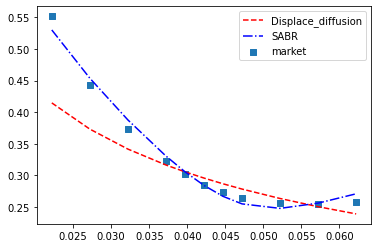

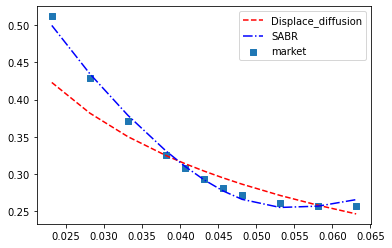

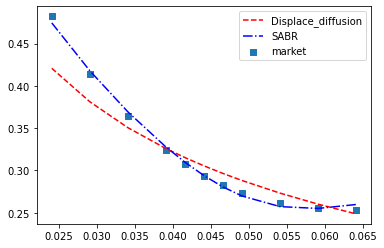

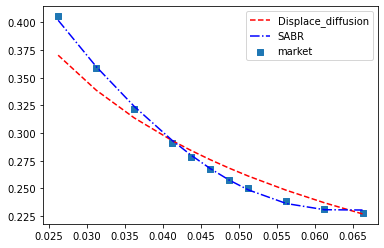

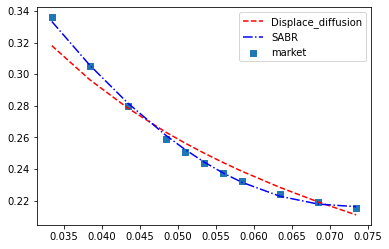

In [28]:
# plot the DD model and SABR model
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        SABR_vols = [sabrvol(fwd, i, pvbp, T, SABR_Alpha.loc[ex,te], 0.9,
                             SABR_Rho.loc[ex, te], SABR_Nu.loc[ex, te]) for i in strikes]
        
        plt.figure()
        plt.scatter(strikes, market_vols,marker = 's', label= 'market')
        plt.plot(strikes, DD_vols, '--r', label = 'Displace_diffusion')
        plt.plot(strikes, SABR_vols, '-.b', label = 'SABR')
        plt.legend()

In [29]:
SABR_Alpha.to_csv('sabr_alpha.csv')
SABR_Rho.to_csv('sabr_rho.csv')
SABR_Nu.to_csv('sabr_nu.csv')

## 3. Price the swaptions using calibrated Displaced-diffusion and SABR model

In [30]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [31]:
sigma = interpol(1,Cal_Sigma['10Y']['1Y'],5,Cal_Sigma['10Y']['5Y'],2)
beta = interpol(1,Cal_Beta['10Y']['1Y'],5,Cal_Beta['10Y']['5Y'],2)

In [32]:
alpha=interpol(1,SABR_Alpha['10Y']['1Y'],5,SABR_Alpha['10Y']['5Y'],2)
rho=interpol(1,SABR_Rho['10Y']['1Y'],5,SABR_Rho['10Y']['5Y'],2)
nu=interpol(1,SABR_Nu['10Y']['1Y'],5,SABR_Nu['10Y']['5Y'],2)

In [33]:
# for payer 2y x 10y
fwd1 = 0.03931739428975305
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = 0.5 * sum(semi_annual_DF.OIS_DF[2*2:(2+10)*2])

In [34]:
payer_DD = [DD_Call(fwd1, i, sigma, pvbp1, beta, T) for i in strikes]    

In [35]:
payer_SABR=[Black76Call(fwd1,i,SABR(fwd1,i,T,alpha,0.9,rho,nu),pvbp1, T) for i in strikes]

In [36]:
payer = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR})
payer

,Strikes,Displaced Diffusion,SABR
0,0.01,0.285074,0.286549
1,0.02,0.191945,0.195326
2,0.03,0.109669,0.112482
3,0.04,0.049433,0.050289
4,0.05,0.016373,0.020553
5,0.06,0.003761,0.010383
6,0.07,0.000575,0.006430
7,0.08,0.000057,0.004521


In [37]:
# for receiver 8x10y
fwd2 = 0.04857351456216663
pvbp2 = 0.5 * sum(semi_annual_DF.OIS_DF[8*2:(8+10)*2])
T = 8

In [38]:
sigma = interpol(5,Cal_Sigma['10Y']['5Y'],10,Cal_Sigma['10Y']['10Y'],8)
beta = interpol(5,Cal_Beta['10Y']['5Y'],10,Cal_Beta['10Y']['10Y'],8)

In [39]:
alpha=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

In [40]:
rec_DD = [DD_Put(fwd2, i, sigma, pvbp2, beta, T) for i in strikes]
rec_SABR=[Black76Put(fwd2, i, SABR(fwd2,i,T,alpha,0.9,rho,nu), pvbp2, T) for i in strikes]

In [41]:
receiver = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR})
receiver

,Strikes,Displaced Diffusion,SABR
0,0.01,0.018965,0.019287
1,0.02,0.033913,0.038477
2,0.03,0.056720,0.061179
3,0.04,0.089154,0.090345
4,0.05,0.132365,0.130563
5,0.06,0.186619,0.186654
6,0.07,0.251244,0.258195
7,0.08,0.324804,0.339612
